<h2> Machine Learning for crop detection</h2>

In this notebook machine learning techniquey will be used to predict crops on fields based on their spectral signature. The "ground truth data" will be used from the [US Cropland Data Layer](https://nassgeodata.gmu.edu/CropScape/). From this layer the 5 most common crops for 2019 in the area of interest in North Dakota were chosen and downloaded as raster masks.

The training date will be Sentinel-2 data of 2019. The band 1-9 are being used.

A Decision Tree Classifier and a Random Forest Classifier will be trained on the data to see if the 9-band information is enough to classifiy the crops

In [1]:
# necessary Imports


import os
import numpy as np 
import geojson
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#import matplotlib.cm as cm
from IPython.display import Image

from helper_functions import RasterHelper
# geodata specific imports
import gdal
import rasterio
from rasterio.mask import mask

from geojson import Polygon

In [2]:


aoi= [{'type': 'Polygon', 'coordinates': [[[-10821406, 6029867], [-10821406, 6067979], [-10768297, 6067979], [-10768297, 6029867], [-10821406, 6029867]]]}]

In [3]:
croplist = ["Corn", "Dry_Beans" , "Soy_Beans", "Sugar_Beets", "Spring_Wheat"]

In [4]:
crop_arrays = []
for i, crop in enumerate(croplist):
    raster = rasterio.open(f'sample_data/NorthDakota/classification/{crop}_3857.tif')

    out_img, out_transform = mask(raster, shapes=aoi, crop=True)
    array = out_img[0]
    array = np.where(array == 0, np.nan, array)
    array = np.where(array == np.nanmean(array), i+1, np.nan)
    crop_arrays.append(array)

crop_array = np.array(crop_arrays)

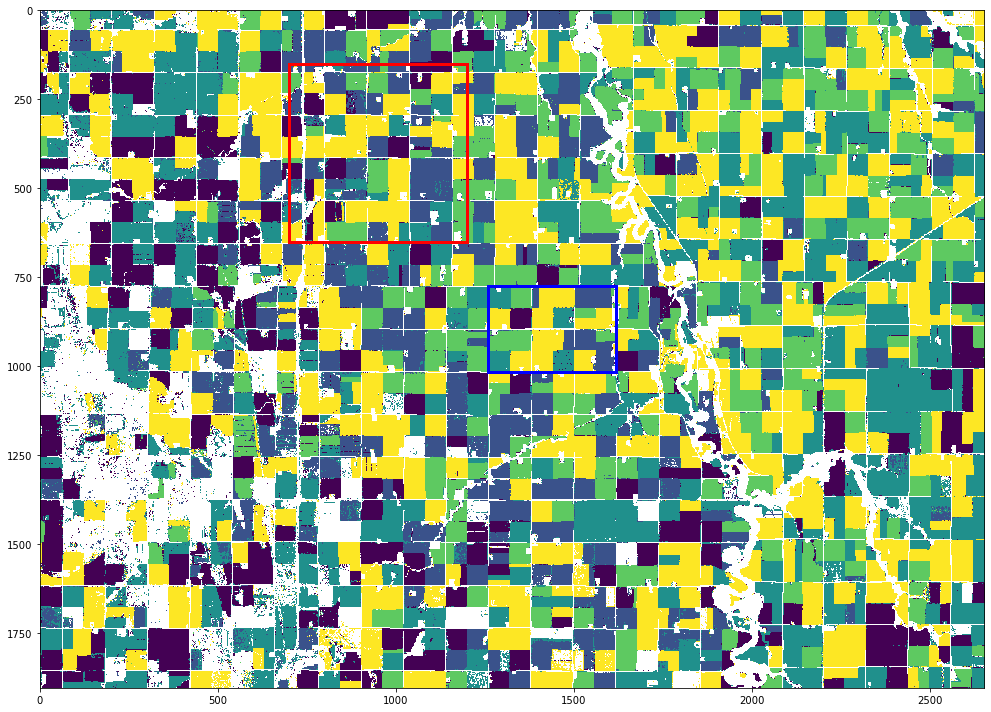

In [77]:
cropsum = np.nansum(crop_array, axis=0)
cropsum = np.where(cropsum == 0, np.nan, cropsum)
cropsum = cropsum[1:-2,:-2]

fig, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(cropsum)
rect_train = patches.Rectangle((700,150),500,500, linewidth=3,edgecolor='r',facecolor='none')
rect_test = patches.Rectangle((1260,775),360,240, linewidth=3,edgecolor='b',facecolor='none')
ax.add_patch(rect_train)
ax.add_patch(rect_test)
plt.tight_layout()

In [10]:
# open data sets

dir = "sample_data/NorthDakota/Sentinel"
# loop over directory and open all single band tiffs
helper = RasterHelper()
multiband_array = helper.open_multiband_scene(directory=dir, aoi=aoi)




Files were loaded sucessfully. 


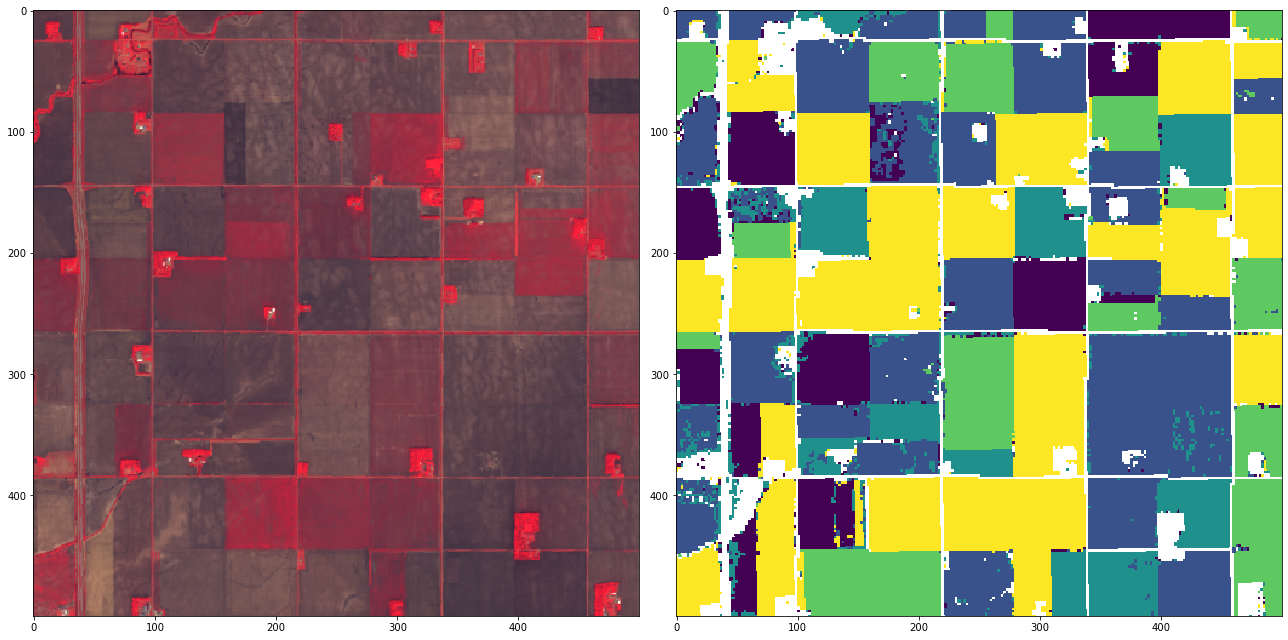

In [69]:


fig, (ax, ax2) = plt.subplots(1,2, figsize=(18,9))
#plot false color Vegetation image
ax.imshow(np.dstack([multiband_array[0][7],multiband_array[0][3],multiband_array[0][1]])[150:650, 700:1200])

#plot label array
ax2.imshow(cropsum)

plt.tight_layout()

In [52]:
cropsum = cropsum[150:650, 700:1200]
cropsum.shape

(500, 500)

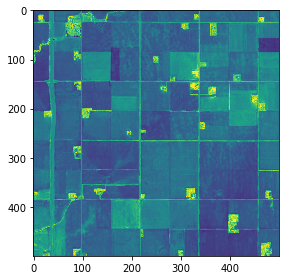

In [53]:
# reduce extent to smaller region
small_array = []

for multiband in multiband_array:
    month = []

    for array in multiband:

        cutout = array[150:650, 700:1200]
        month.append(cutout)

    small_array.append(month)

small_array= np.array(small_array)
plt.imshow(small_array[0][7])
plt.tight_layout()


<h2> Prepare data for Machine Learning</h2>

In [54]:
import pandas as pd

In [55]:
signature_array_June = small_array[0].T.reshape(-1,9)
signature_array_Sept = small_array[1].T.reshape(-1,9)
label_array = cropsum.T.reshape(-1,1)

In [56]:
df_1 = pd.DataFrame(signature_array_June, columns=['Jun_B1','Jun_B2','Jun_B3','Jun_B4','Jun_B5','Jun_B6','Jun_B7','Jun_B8','Jun_B9'])
df_2 = pd.DataFrame(signature_array_Sept, columns=['Sep_B1','Sep_B2','Sep_B3','Sep_B4','Sep_B5','Sep_B6','Sep_B7','Sep_B8','Sep_B9'])
label = pd.DataFrame(label_array, columns=['Label'])

In [57]:
df = pd.concat([df_1, df_2, label], axis=1)

In [58]:
#df = df.dropna()
X = df.drop(['Label'], axis=1)
y = df["Label"]

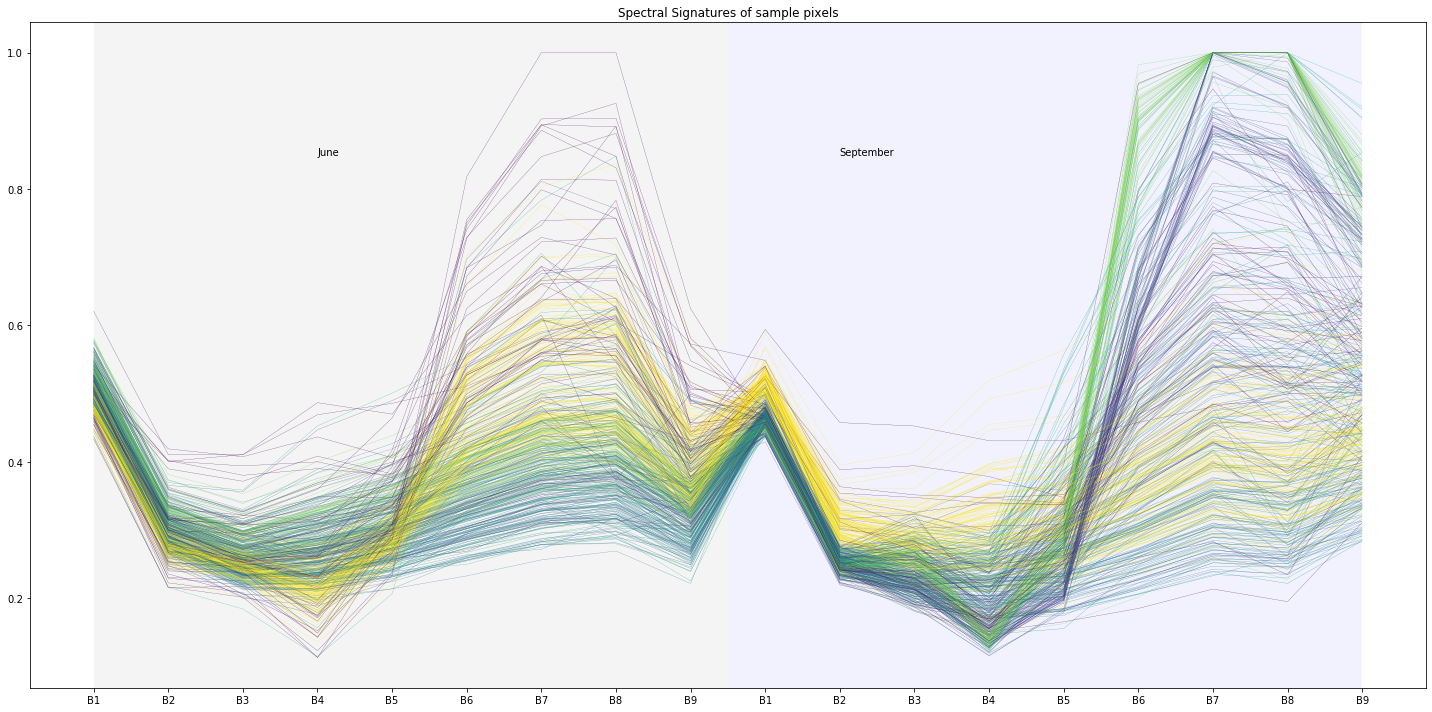

In [133]:
import matplotlib as mpl
from matplotlib import cm

sample = df.sample(n=500)
sample_X = np.array(sample.drop(['Label'], axis=1))
sample_y = sample["Label"]

labelist = ["Nan", "Corn", "Dry_Beans" , "Soy_Beans", "Sugar_Beets", "Spring_Wheat"]
fig, ax = plt.subplots(figsize=(20, 10))
for y, f in zip(sample_X, sample_y):
    ax.plot(range(18), y,  c=cm.viridis(f/5), linewidth=0.2 )

plt.axvspan(0, 8.5, facecolor='0.2', alpha=0.1)
plt.axvspan(8.5, 17, facecolor='b', alpha=0.1)

plt.text(3,0.85, "June")
plt.text(10,0.85, "September")
plt.xticks(np.arange(18), ('B1','B2','B3','B4','B5','B6','B7','B8','B9','B1','B2','B3','B4','B5','B6','B7','B8','B9'))
plt.title("Spectral Signatures of sample pixels")
plt.tight_layout()

In [60]:
df["Label"] = df["Label"].fillna(0)

In [61]:
#df = df.fillna(0)
df

,Jun_B1,Jun_B2,Jun_B3,Jun_B4,Jun_B5,Jun_B6,Jun_B7,Jun_B8,Jun_B9,Sep_B1,Sep_B2,Sep_B3,Sep_B4,Sep_B5,Sep_B6,Sep_B7,Sep_B8,Sep_B9,Label
0,0.500360,0.303502,0.256001,0.269749,0.292256,0.336004,0.365743,0.388495,0.300712,0.486475,0.271748,0.231495,0.238499,0.249744,0.289754,0.326497,0.314244,0.370035,2.0
1,0.499270,0.304753,0.258244,0.269001,0.287999,0.331746,0.367742,0.387747,0.299135,0.485007,0.269245,0.233753,0.241993,0.254246,0.292256,0.326253,0.316503,0.377045,2.0
2,0.498202,0.299245,0.254994,0.265248,0.283757,0.323995,0.362997,0.377493,0.297581,0.483515,0.270756,0.233005,0.241001,0.259251,0.294743,0.334997,0.325002,0.381647,2.0
3,0.497134,0.293248,0.248753,0.259495,0.280003,0.318257,0.355505,0.375494,0.296004,0.482770,0.267994,0.233249,0.242252,0.261006,0.294743,0.340002,0.328756,0.385116,2.0
4,0.495717,0.290501,0.244999,0.254994,0.276997,0.315999,0.347753,0.368002,0.294045,0.481662,0.269993,0.233997,0.247501,0.258503,0.292500,0.338750,0.330755,0.385116,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0.525341,0.319753,0.280247,0.303243,0.324254,0.364752,0.400504,0.420249,0.321838,0.460556,0.248997,0.259007,0.137255,0.271748,0.925246,1.000000,1.000000,0.860794,4.0
249996,0.523575,0.316243,0.275257,0.297749,0.322255,0.360754,0.396506,0.414252,0.315983,0.460556,0.248753,0.255497,0.140993,0.268757,0.914000,1.000000,1.000000,0.857325,4.0
249997,0.521787,0.311254,0.269001,0.287755,0.317006,0.352743,0.389502,0.402243,0.312064,0.461302,0.248493,0.258244,0.140749,0.267994,0.897993,1.000000,1.000000,0.845713,4.0
249998,0.520349,0.309255,0.264500,0.282750,0.311498,0.345251,0.381247,0.396246,0.312446,0.462793,0.248997,0.253254,0.138506,0.268498,0.885496,1.000000,1.000000,0.821355,4.0


In [62]:
# Sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Sklearn utility functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [63]:
# Generate a train and val split 
my_train_prop = 0.66
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  train_size = my_train_prop, test_size  = 1 - my_train_prop, 
                                                  random_state = 1)

In [64]:

# Create a logistic regression model
my_reg_mod = LogisticRegression(penalty = 'l2', C = 1, solver = 'liblinear')
my_reg_mod.fit(X_train, y_train)
# Predict validation data and compute accuracy
my_reg_mod_acc = accuracy_score(y_val, my_reg_mod.predict(X_val))
print('Logistic regression accuracy:', my_reg_mod_acc)


Logistic regression accuracy: 0.8484470588235294


In [70]:

# Create classification tree
my_tree_mod = tree.DecisionTreeClassifier(criterion = 'gini')
my_tree_mod.fit(X_train, y_train)
# Predict validation data and compute accuracy
my_tree_mod_acc = accuracy_score(y_val, my_tree_mod.predict(X_val))
print('Classification tree accuracy:', my_tree_mod_acc)


Classification tree accuracy: 0.9068352941176471


In [71]:

# Create random forest
my_forest_mod = RandomForestClassifier(criterion = 'gini', n_estimators = 500, n_jobs=-2)
my_forest_mod.fit(X_train, y_train)
# Predict validation data and compute accuracy
my_forest_mod_acc = accuracy_score(y_val, my_forest_mod.predict(X_val))
print('Random forest accuracy:', my_forest_mod_acc)

Random forest accuracy: 0.9453764705882353


In [16]:
clusters = np.reshape(np.array(y), (cropsum.shape[1], cropsum.shape[0]))
cluster_img = np.flip(np.rot90(clusters, 3), 1)

ValueError: cannot reshape array of size 4164963 into shape (2656,1907)

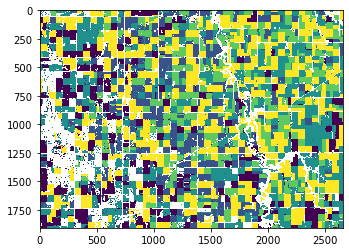

In [34]:
plt.imshow(cluster_img)